In [24]:
source('../src/load_data.r')
bh2 <- BostonHousing2

In [54]:
source('../src/handy_fns.r')

In [25]:
# dplyr is a grammar of data manipulation, providing a consistent set of verbs that 
# help you solve the most common data manipulation challenges
library(dplyr, warn.conflicts = FALSE); library(ggplot2); library(GGally)

### selecting a small sample of the dataset

setting seed so that I get the same random values everytime I run this notebookin

In [26]:
set.seed(10)

In [27]:
n_obs <- dim(bh2)[1]
sample_ <- bh2[sample(1:n_obs, 3, replace=FALSE),]

In [28]:
sample_

,medv,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
3861,44,0.01538,90,3.75,0,0.394,7.454,34.2,6.3361,3,244,15.9,386.34,3.11
3533,17,1.41385,0,19.58,1,0.871,6.129,96.0,1.7494,5,403,14.7,321.02,15.12
3691,25,0.19802,0,10.59,0,0.489,6.182,42.4,3.9454,4,277,18.6,393.63,9.47


##### comparing this sample to the dataset as a whole

In [29]:
library(moments)

#### `lapply()` "family" of functions
The `sapply()` function works like `lapply()`, but it tries to simplify the output to the most elementary data structure that is possible. And indeed, `sapply()` is a ‘wrapper’ function for `lapply()`.

    # Return a list with `lapply()`
    lapply(MyList,"[", 2, 1 )
    
    # Return a vector with `sapply()`
    sapply(MyList,"[", 2, 1 )
    
    # Return a vector with `unlist()`
    unlist(lapply(MyList,"[", 2, 1 ))

In [30]:
bh2_num_feat <- Filter(is.numeric, bh2)
stats <- data.frame(feature = colnames(bh2_num_feat))
stats['mean_'] <- sapply(bh2_num_feat, mean)
stats['median_'] <- sapply(bh2_num_feat, median)
stats['sd_'] <- sapply(bh2_num_feat, sd)
stats['skewness_'] <- sapply(bh2_num_feat, skewness)
stats

feature,mean_,median_,sd_,skewness_
medv,22.5328063,21.20000,9.1971041,1.1048108
crim,3.6135236,0.25651,8.6015451,5.2076524
zn,11.3636364,0.00000,23.3224530,2.2190631
indus,11.1367787,9.69000,6.8603529,0.2941463
nox,0.5546951,0.53800,0.1158777,0.7271442
rm,6.2846344,6.20850,0.7026171,0.4024147
age,68.5749012,77.50000,28.1488614,-0.5971856
dis,3.7950427,3.20745,2.1057101,1.0087788
rad,9.5494071,5.00000,8.7072594,1.0018335
tax,408.2371542,330.00000,168.5371161,0.6679683


In [31]:
sapply(Filter(is.numeric, sample_), mean)

medv        crim          zn       indus         nox          rm 
 28.6666667   0.5424167  30.0000000  11.3066667   0.5846667   6.5883333 
        age         dis         rad         tax     ptratio           b 
 57.5333333   4.0103000   4.0000000 308.0000000  16.4000000 366.9966667 
      lstat 
  9.2333333

##### converting samples to z-scores 

In [32]:
sample_num_feat <- Filter(is.numeric, sample_)
n_num_feat <- length(sample_num_feat)
for (i in 1:n_num_feat) {
    col_ <- sample_num_feat[, i]
    mean_ <- mean(col_); sd_ <- sd(col_)
    col_z <- (col_ - mean_) / sd_
    
    if (i != 1) {
        sample_z <- cbind(sample_z, col_z)  
    }
    # R won't let you create an empty dataframe
    else {
        sample_z <- data.frame(col_z)
        rownames(sample_z) <- rownames(sample_num_feat)
    }
}
colnames(sample_z) <- colnames(sample_num_feat)
sample_z

,medv,crim,zn,indus,nox,rm,age,dis,rad,tax,ptratio,b,lstat
3861,1.1056287,-0.6932974,1.1547005,-0.95180554,-0.7551742,1.1539798,-0.6951797,1.01384518,-1,-0.7627159,-0.2503131,0.4837835,-1.01911236
3533,-0.8412392,1.1463387,-0.5773503,1.04207382,1.1340816,-0.6123158,1.1460533,-0.98555446,1,1.1321564,-0.8510645,-1.1498924,0.97972370
3691,-0.2643895,-0.4530412,-0.5773503,-0.09026828,-0.3789074,-0.5416640,-0.4508737,-0.02829072,0,-0.3694405,1.1013776,0.6661089,0.03938867


##### preparing a heatmap my samples and of the sample z-scores

In [33]:
library(reshape2)

In [46]:
sample_z_m <- sample_z
sample_z_m['tract'] <- rownames(sample_z)
sample_z_m <- melt(sample_z_m, id.vars = 'tract')

In [47]:
colnames(sample_z_m)[colnames(sample_z_m) == 'value'] <- 'zscr'

In [48]:
head(sample_z_m, 4)

tract,variable,zscr
3861,medv,1.1056287
3533,medv,-0.8412392
3691,medv,-0.2643895
3861,crim,-0.6932974


In [56]:
heatmap <- function(melted_data, xx, yy, heatspots) {    
    options(repr.plot.width = length(unique(melted_data[[xx]])), 
            repr.plot.height = length(unique(melted_data[[yy]])))
    
    
    
    plt <- ggplot(melted_data, aes_string(x = xx, y = yy, fill = heatspots)) +
                    geom_tile(color = 'white') +
                    geom_text(aes_string(label = paste('round(as.numeric(', heatspots, '), digits = 2)')),
                                         size = 7, color = 'white') +
                    theme(axis.text.x = element_text(angle = 45, vjust = 1, 
                                                     size = length(unique(melted_data[[xx]]))*2, 
                                                     hjust = 1))
    
    return(plt)
}

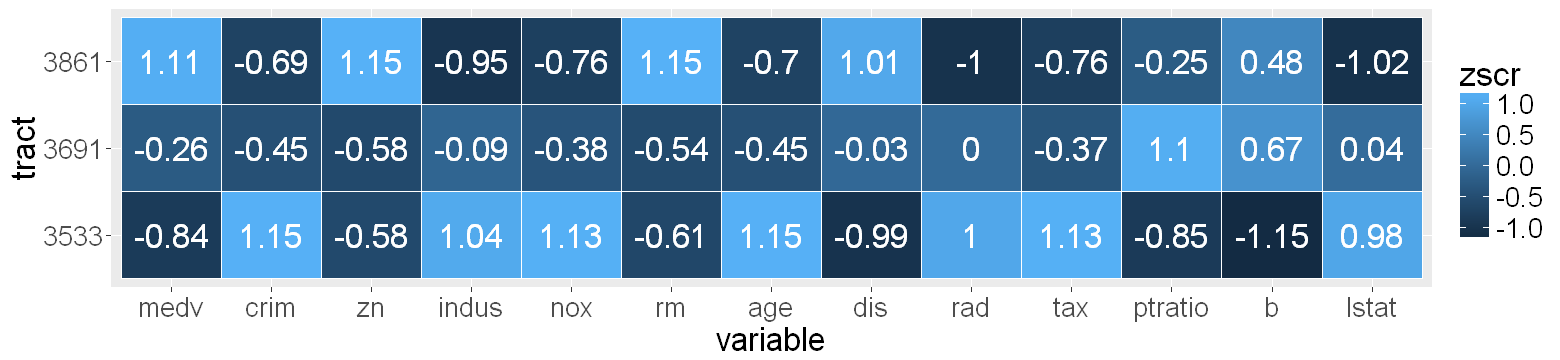

In [72]:
z_heatmap <- heatmap(sample_z_m, xx = 'variable', yy = 'tract', heatspots = 'zscr')
z_heatmap <- z_heatmap + 
                theme(text = element_text(size = 20))
print(z_heatmap)

In [39]:
sample_melt <- sample_
sample_melt['tract'] <- rownames(sample_melt)
sample_melt <- melt(sample_melt, id.var = 'tract')

Warning message:
"attributes are not identical across measure variables; they will be dropped"

In [40]:
head(sample_melt, 3)

tract,variable,value
3861,medv,44
3533,medv,17
3691,medv,25


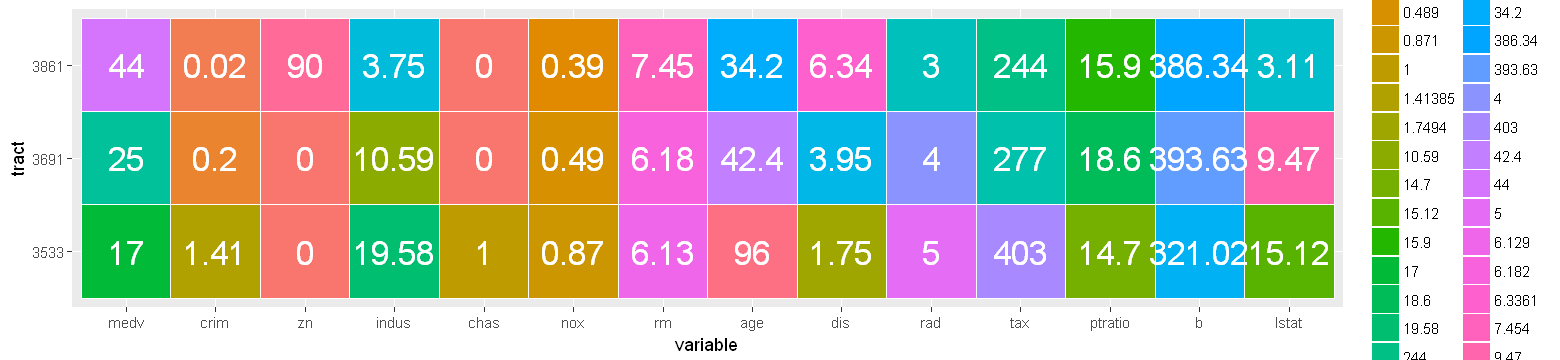

In [41]:
sample_heatmap <- heatmap(sample_melt, xx = 'variable', yy = 'tract', heatspots = 'value')
print(sample_heatmap)

##### preparing a speculation as to what each sample might represent and discuss whether values across categories can be easily compared
Each sample is a randomly selected sample from the dataset with replacement. That means that in terms of Probability, the samples are independent and identically distributed. Thus, the Central Limit Theorem applies. We scale the sample and make them z-scores so that we can compare the spread of the sample distribution. 

#### Central Limit Thm
Assumptions:
    Let  
    1. S_n = X1 + X2 + ... + Xn  
    2. E[S_n] = nE[X1] = n(mu)  [X1, X2, ... , Xn are independent and identically distributed]  
    3. sd[S_n] = sqrt(n*var[X1]) = (sigma)*sqrt(mu)  
Therefore:
    (S_n - n(mu)) / [(sigma)sqrt(n)] => Normal(mean=0, sd = 1)
 